<a href="https://colab.research.google.com/github/anuj1o0/Satellite-image-classification/blob/main/Satellite_image_Classification_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tensorflow==2.15.0 tensorflow_addons tensorflow_datasets tensorflow_hub numpy matplotlib seaborn scikit-learn

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# Print the number of samples in each dataset split
print(f"Total training samples: {len(list(train_ds))}")
print(f"Total validation samples: {len(list(valid_ds))}")
print(f"Total testing samples: {len(list(test_ds))}")

In [ ]:
# Using .cardinality() to check number of samples
print(f"Training samples: {train_ds.cardinality()}")
print(f"Validation samples: {valid_ds.cardinality()}")
print(f"Testing samples: {test_ds.cardinality()}")


In [ ]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

In [ ]:
# make a plot for number of samples on each class
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32),
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [ ]:
# def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
#   if cache:
#     if isinstance(cache, str):
#       ds = ds.cache(cache)
#     else:
#       ds = ds.cache()
#   ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
#   # ds = ds.map(lambda d: (d["sentinel2"], tf.one_hot(d["label"], num_classes)))
#   # shuffle the dataset
#   ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#   # Repeat forever
#   ds = ds.repeat()
#   # split to batches
#   ds = ds.batch(batch_size)
#   # `prefetch` lets the dataset fetch batches in the background while the model
#   # is training.
#   ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#   return ds

In [ ]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    # Data augmentation
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return image, label

    ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
    ds = ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [ ]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

In [ ]:
# take the first batch of the training set
batch = next(iter(train_ds))

In [ ]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

In [ ]:
from tensorflow.keras.applications import VGG16

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    base_model = VGG16(include_top=False, input_shape=(64, 64, 3), weights="imagenet")
    base_model.trainable = True

    m = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    m.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
    )

In [ ]:
m.summary()

In [ ]:
import os
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [ ]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [17]:
history = m.fit(
    train_ds,
    validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1,
    epochs=20,
    callbacks=[model_checkpoint]
)

Epoch 1/20
253/253 [==============================] - ETA: 0s - loss: 2.1970 - accuracy: 0.3184 - f1_score: 0.2881
Epoch 1: val_loss improved from inf to 1.46356, saving model to results/satellite-classification.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 38s 88ms/step - loss: 2.1970 - accuracy: 0.3184 - f1_score: 0.2881 - val_loss: 1.4636 - val_accuracy: 0.4139 - val_f1_score: 0.3137
Epoch 2/20
253/253 [==============================] - ETA: 0s - loss: 1.3571 - accuracy: 0.4494 - f1_score: 0.4120
Epoch 2: val_loss improved from 1.46356 to 1.27470, saving model to results/satellite-classification.h5
253/253 [==============================] - 22s 87ms/step - loss: 1.3571 - accuracy: 0.4494 - f1_score: 0.4120 - val_loss: 1.2747 - val_accuracy: 0.4909 - val_f1_score: 0.4548
Epoch 3/20
253/253 [==============================] - ETA: 0s - loss: 1.0862 - accuracy: 0.5771 - f1_score: 0.5529
Epoch 3: val_loss improved from 1.27470 to 0.95507, saving model to results/satellite-classification.h5
253/253 [==============================] - 22s 86ms/step - loss: 1.0862 - accuracy: 0.5771 - f1_score: 0.5529 - val_loss: 0.9551 - val_accuracy: 0.6192 - val_f1_score: 0.5995
Epoch 4/20
253/253 [=================

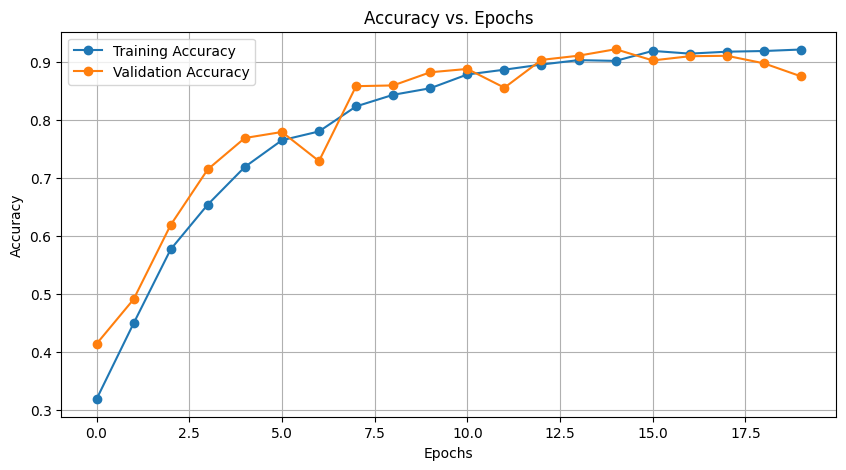

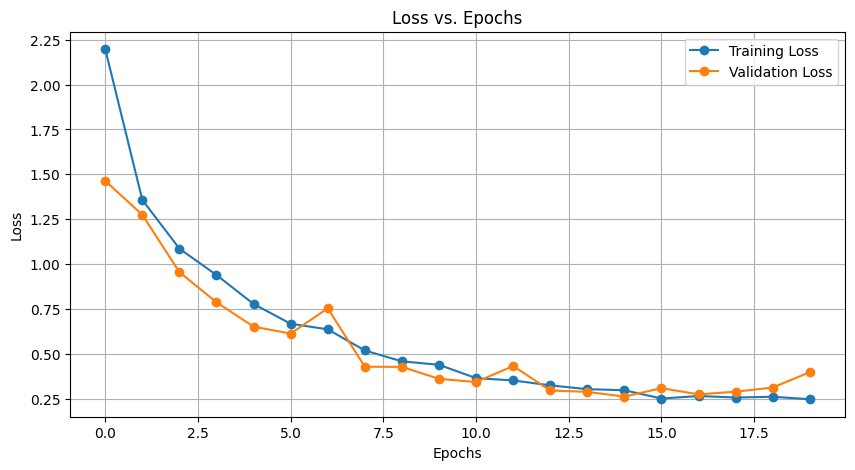

In [18]:
# Extract metrics from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# load the best weights
m.load_weights(model_path)

In [20]:
# number of testing steps
n_testing_steps = int(all_ds[1].splits["train"].num_examples * 0.2)

In [21]:
# get all testing images as NumPy array
images = np.array([ d["image"] for d in test_ds.take(n_testing_steps) ])
print("images.shape:", images.shape)

images.shape: (5400, 64, 64, 3)


In [22]:
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])
print("labels.shape:", labels.shape)

labels.shape: (5400,)


In [24]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

169/169 [==============================] - 5s 19ms/step
predictions.shape: (5400,)


In [25]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9218519
F1 Score: 0.9212187351716148


In [ ]:
# from sklearn.metrics import f1_score

# accuracy = tf.keras.metrics.Accuracy()
# accuracy.update_state(labels, predictions)
# print("Accuracy:", accuracy.result().numpy())
# print("F1 Score:", f1_score(labels, predictions, average="macro"))
#dialated

Accuracy: 0.92351854
F1 Score: 0.9216569988466224


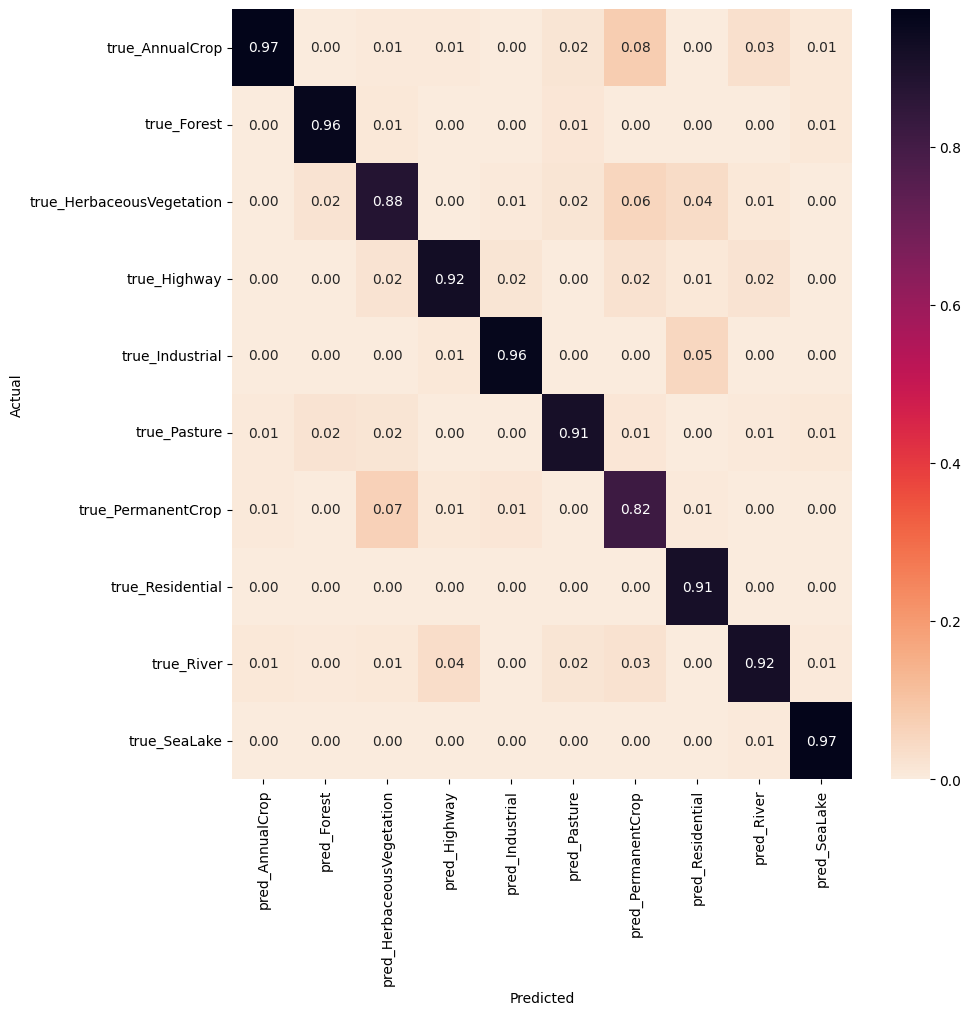

In [26]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype('float') / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
            xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

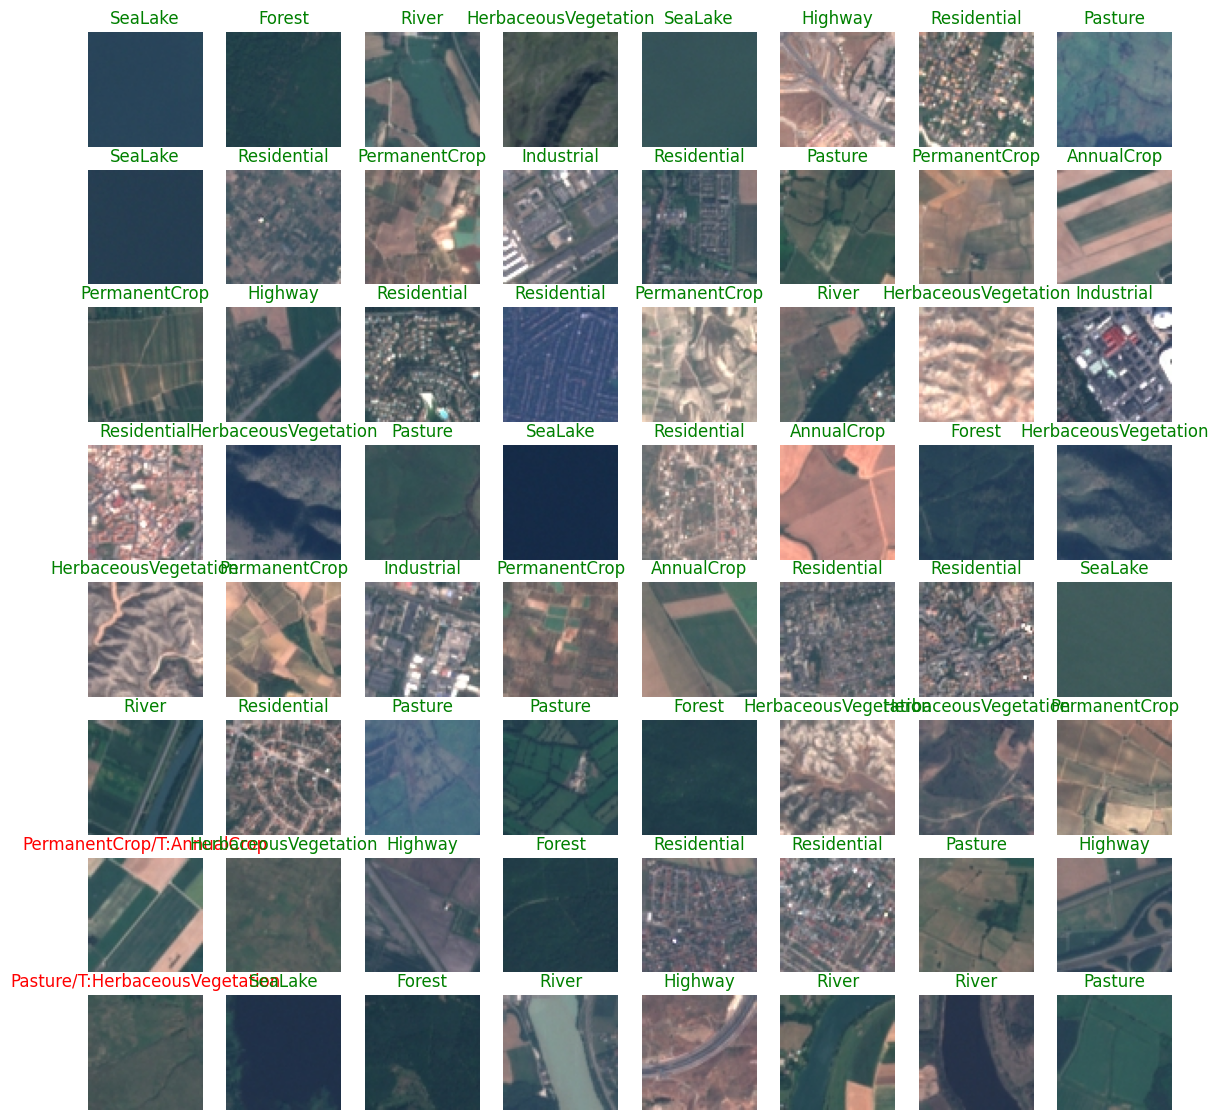

In [27]:
def show_predicted_samples():
  plt.figure(figsize=(14, 14))
  for n in range(64):
      ax = plt.subplot(8, 8, n + 1)
      # show the image
      plt.imshow(images[n])
      # and put the corresponding label as title upper to the image
      if predictions[n] == labels[n]:
        # correct prediction
        ax.set_title(class_names[predictions[n]], color="green")
      else:
        # wrong prediction
        ax.set_title(f"{class_names[predictions[n]]}/T:{class_names[labels[n]]}", color="red")
      plt.axis('off')
      plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()